# Loadsmart Challenge - Afonso Menegola

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np

import xgboost

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import sklearn
from sklearn import neighbors
from sklearn import neural_network
from sklearn import svm
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble

from sklearn.pipeline import Pipeline

from scipy import stats

import dill as pickle

import requests
import json


## Let's Import the data

In [3]:
data = pd.read_csv('data/train_data.csv')
data.head()

,x1,x2,x3,y
0,9.262865,0.000793,0,-299.270637
1,-5.285342,0.000076,1,-160.034460
2,1.629662,0.000781,0,-289.977892
3,-5.465603,0.000081,0,-371.694070
4,9.331821,0.001335,1,492.664677


## Exploratory Analysis

After loading the data, I'm going to perform some Exploratory Analysis, to take a closer look at the data. Interesting results could be obtained, and these results could guide me to select the best model for prediction.

It seems I have three predictors (x1 - float, x2 - float, x3 - categorical) and a response variable y - float, characterizing a regression task.

First, let's plot some histograms:

Text(0.5,1,'y')

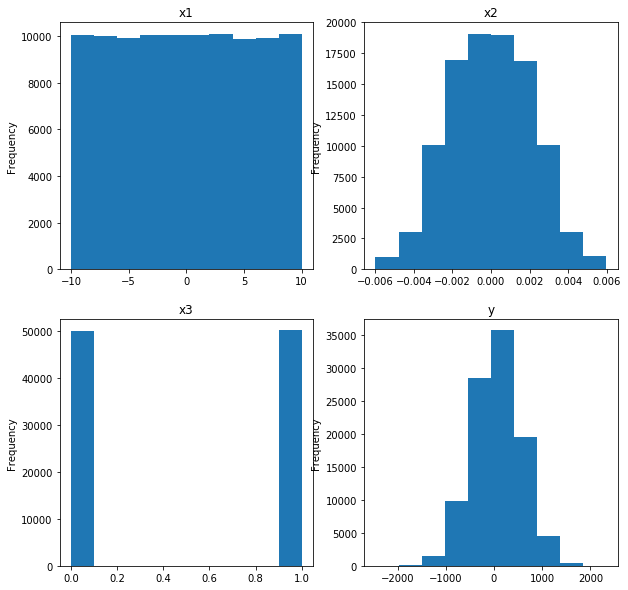

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

data.x1.plot(kind='hist', ax=axes[0,0]); axes[0,0].set_title('x1')

data.x2.plot(kind='hist', ax=axes[0,1]); axes[0,1].set_title('x2')

data.x3.plot(kind='hist', ax=axes[1,0]); axes[1,0].set_title('x3')

data.y.plot(kind='hist', ax=axes[1,1]); axes[1,1].set_title('y')

It seems that x1 predictor acts as a uniform distribution, the x2 as a normal distribution, and x3 is practically dividing the data in two. The response variable y is normal-like, with some skewness.

Since x3 practically divides the data, let's use this information and plot the histograms of the other two predictors and response variable to see what happens:

In [5]:
data_0 = data[data.x3 == 0].drop(['x3'],axis=1)
data_1 = data[data.x3 == 1].drop(['x3'],axis=1)

Text(0.5,1,'y')

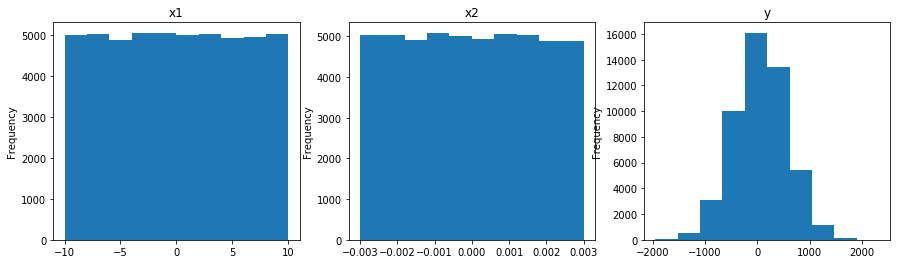

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

data_0.x1.plot(kind='hist', ax=axes[0]); axes[0].set_title('x1')

data_0.x2.plot(kind='hist', ax=axes[1]); axes[1].set_title('x2')

data_0.y.plot(kind='hist', ax=axes[2]); axes[2].set_title('y')

Text(0.5,1,'y')

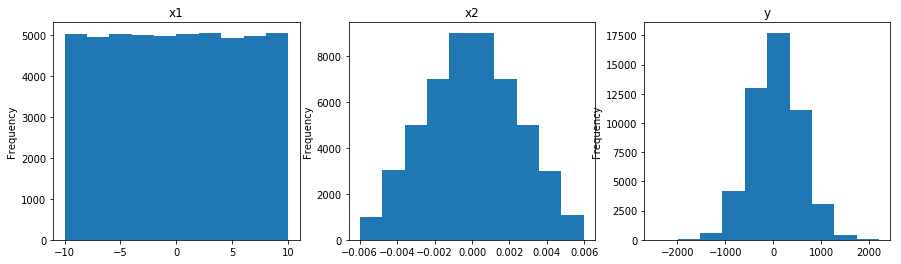

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

data_1.x1.plot(kind='hist', ax=axes[0]); axes[0].set_title('x1')

data_1.x2.plot(kind='hist', ax=axes[1]); axes[1].set_title('x2')

data_1.y.plot(kind='hist', ax=axes[2]); axes[2].set_title('y')

Interesting! When x3 is 0, x2 behaves as a uniform distribution, and when x3 is 1, x2 behaves as a perfect gaussian centered at zero. The response variable also appears to change the skewness a little bit. When x3 is 0, we have a right skewness, and when x3 is 1, we have a left skewness:

In [11]:
print('The skewness of y when x3 is 0 is: {}'.format(stats.skew(data_0.y)))
print('The skewness of y when x3 is 1 is: {}'.format(stats.skew(data_1.y)))

The skewness of y when x3 is 0 is: -0.00157977309978979
The skewness of y when x3 is 1 is: 0.010614310893324076


But the overall description of both response variables is almost the same:

In [15]:
data_0.y.describe()

count    49927.000000
mean        63.667986
std        504.572453
min      -1950.076776
25%       -274.984792
50%         66.582909
75%        404.671496
max       2326.356392
Name: y, dtype: float64

In [16]:
data_1.y.describe()

count    50073.000000
mean        64.495390
std        503.729804
min      -2459.738984
25%       -277.495405
50%         63.086044
75%        405.537582
max       2211.161159
Name: y, dtype: float64

Since we have no presence of outliers, I'm going to go ahead and standardize/normalize this data so that it becomes good to work with prediction models that are variant to this kind of normalization. So, for the predictors which are an uniform distribution I normalize, and for the predictores and response variable wich behaves like a gaussina, I standardize:

In [18]:
X_0 = pd.DataFrame(preprocessing.normalize(data_0[['x1','x2']],norm='max',axis=0),columns=['x1','x2'])
y_0 = preprocessing.StandardScaler().fit_transform(data_0[['y']])

In [19]:
X_1 = pd.DataFrame(preprocessing.normalize(data_1[['x1']],norm='max',axis=0),columns=['x1'])
X_1['x2'] = preprocessing.StandardScaler().fit_transform(data_1[['x2']])
y_1 = preprocessing.StandardScaler().fit_transform(data_1[['y']])

Let's take a look at predictors x1 and x2, and how they relate with each other. I'm going to use kernel density estimation to get a better picture of where the data actually **is**:

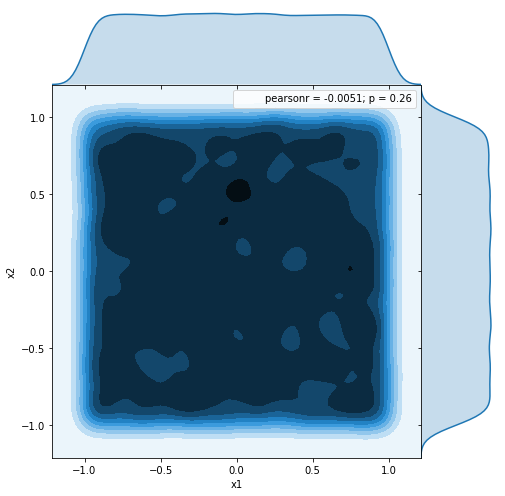

In [20]:
g = sns.jointplot(X_0.x1, X_0.x2, kind="kde", size=7, space=0)

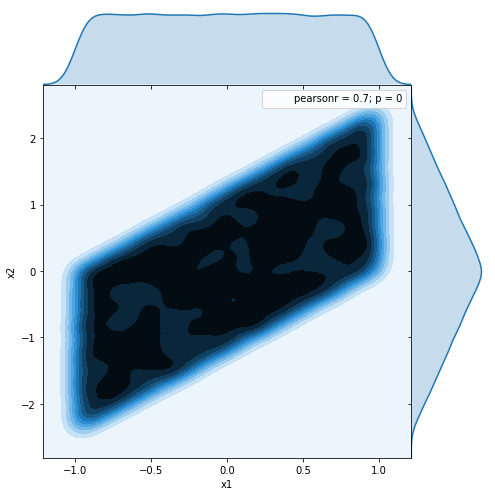

In [21]:
g = sns.jointplot(X_1.x1, X_1.x2, kind="kde", size=7, space=0)

Cool! It looks that when x3 is 0, we have two independent uniform distributions, but when x3 is 1, x1 and x2 have relatively high pearson correlation of 0.7. That's why x2 behaves as a normal distribution, since with this plot we can see that we will have much more data points for x2 around 0 than on the far ends. If we plot both variables together, the data overlaps:

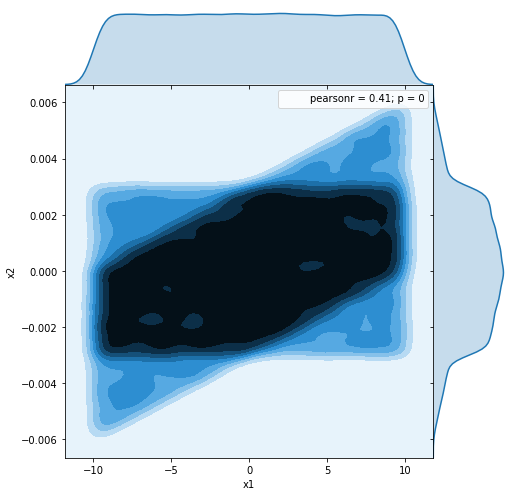

In [22]:
g = sns.jointplot(data.x1, data.x2, kind="kde", size=7, space=0)

Alright, let's take a look now at the response variable y. Let's plot it against both predictors x1 and x2:

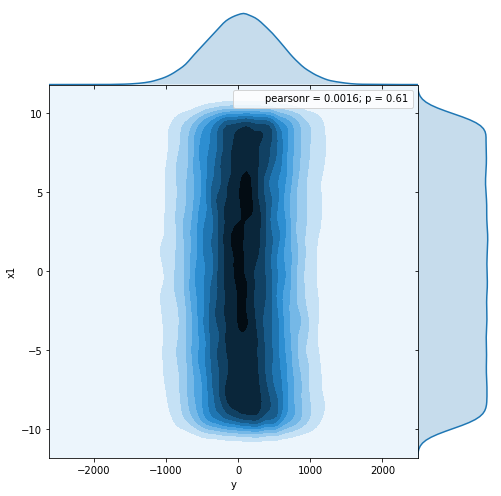

In [28]:
g = sns.jointplot(data.y, data.x1, kind="kde", size=7, space=0)

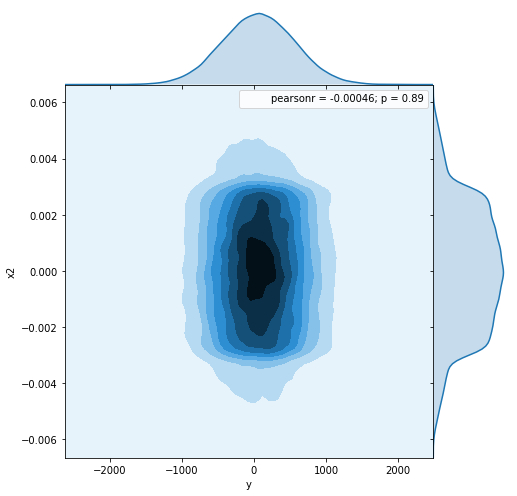

In [29]:
g = sns.jointplot(data.y, data.x2, kind="kde", size=7, space=0)

Frustrating. The response variable has close-to-zero correlation with both predictors, becoming distributed across all its possible value range. In the second plot above, plot of y against x2, we can see the effect of the x2 uniform distribution with the x2 normal distribution, creating that tails. If we plotted x2 when x3 is 0, we would see a shape like the first plot, and if we plotted x2 when x3 is 1, we would see an uncorrelated ellipse.

This exploratory analysis resulted in a bad omen for prediction: I'm not aware of how could I create a good prediction model if both (and only) variables available, are uncorrelated with the response variable. Meaning, if I perform a simple linear regression as baseline, the R² would be zero, since these models would always predict a value as the response distribution mean (which is zero, since I standardized the data).

I could perform data transformations, but it would be pointless: I needed to see some sort of dependence, linear or non-linear. Then I could do some feature engineering, creating combinations of the predictors, or even perform a non linear regression, with different functions, or even I could try more advanced transformations, like Johnson transformation or Box-Cox (if I managed to transform the data to positive values).

Since a linear model would be no good for prediction, I figured using a model that could find some non-linearities to explain the data would be best. Since the result for prediction in R² terms will be bad, I'm not going to try lots of different models, nor perform some hyperparameter optimization. I'm not going to perform some sort of cross validation, because there would be no big difference between the folds, the result will be bad anyway. I'm going to perform only a holdout validation.

I like to use XGBoost models, since they are good, robust models, wich are invariate to normalizations, and can deal with missing values. This will yield a good model, at least trying to capture the best of this data.

In [57]:
#dividing data into train and test. Two splits are using normalized data and one which is not.
X_0_train, X_0_test, y_0_train, y_0_test = model_selection.train_test_split(X_0, y_0, test_size=0.2, random_state=42)
X_1_train, X_1_test, y_1_train, y_1_test = model_selection.train_test_split(X_1, y_1, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = model_selection.train_test_split(data[['x1','x2','x3']], data['y'], test_size=0.2, random_state=42)

In [58]:
#defining a XGB model with 200 estimators
model = xgboost.XGBRegressor(n_estimators=200)

In [59]:
#fitting two models, one for each x3 class, since the standardizations/normalizations are performed differently:
model.fit(X_0_train,y_0_train)
print('Validation Prediction R² when x3 is 0: {0:.2f}%'.format(model.score(X_0_test,y_0_test)*100))
model.fit(X_1_train,y_1_train)
print('Validation Prediction R² when x3 is 1: {0:.2f}%'.format(model.score(X_1_test,y_1_test)*100))

#now, fitting a model which is using raw data
model.fit(X_train,y_train)
print('Validation Prediction R² with raw data: {0:.2f}%'.format(model.score(X_test,y_test)*100))

Validation Prediction R² when x3 is 0: 2.12%
Validation Prediction R² when x3 is 1: 2.05%
Validation Prediction R² with raw data: 2.33%


This is an expected result, close-to-zero R-squared, but not zero, as would be for linear regression. If this data were not synthetic, I would say that there would be no difference between the models, since this model could actually be overfitting (real data could generate non seen data, drastically degrading performance).

We can see that the XGB model deals well with raw data, simplifying the model implementation in the API.

## Bulding the model for the API

I'm going to build this model as a sklearn pipeline, so that this code can be easily improved:

In [60]:
#creating model pipeline
pipe = Pipeline([
    ('xgb', xgboost.XGBRegressor(n_estimators=200))
])

In [61]:
#fitting pipeline with all raw data
pipe.fit(data[['x1','x2','x3']],data.y)

Pipeline(memory=None,
     steps=[('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [62]:
filename = 'model_v1.pk'
with open('models/'+filename, 'wb') as file:
    pickle.dump(pipe, file)

## Testing the API with check_data.csv

In [125]:
#reading test data
check_data = pd.read_csv('data/check_data.csv')
check_data.head()

,x1,x2,x3
0,4.397037,0.001943,0
1,-2.783894,0.002305,0
2,-0.528724,0.002909,0
3,4.321660,0.003909,1
4,-2.640812,-0.001368,1


In [129]:
#Setting the headers to send and accept json responses
header = {'Content-Type': 'application/json', \
                  'Accept': 'application/json'}

#defining array of predictions
predictions = []

check_data_dict = check_data.to_dict(orient='index')
for i in range(len(check_data)):
    
    #running POST on API
    resp = requests.post("http://127.0.0.1:8080/predict", \
                    data = json.dumps(check_data_dict[i]),\
                    headers= header)
    
    #save prediction
    predictions.append(resp.json()['y'])
    
#save prediction to csv file
predictions = pd.DataFrame(predictions,columns=['y'])
predictions.to_csv('data/check_data_predicted.csv',index=False)

In [149]:
#it's predicting with close-to-mean values
predictions.astype(float).describe()

,y
count,10000.000000
mean,63.739157
std,74.287997
min,-338.679000
25%,14.546597
50%,38.614062
75%,93.222230
max,590.536900


## Check for errors

In [159]:
resp = requests.post("http://127.0.0.1:8080/predict", \
                    data = json.dumps({'x2': 0.002, 'x3': 'test'}),\
                    headers= header)

In [160]:
resp.status_code

422

In [161]:
resp.json()

{'x1': 'x1 is missing', 'x3': 'x3 should be int'}